In [5]:
import sys
#sys.path.append("/home/ubuntu/projects/ts-graph-inference/")

#from ts_graph_inference.data_utils import *
import seaborn as sns
import matplotlib.pyplot as plt


import msprime
#import allel
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd

In [6]:
def get_population_time(time_rate:float=0.06, tmax:int = 130_000,
                        num_time_windows:int = 21
                       ) -> np.array :
    """Creates population time points; used as time points to change
    population size changes for simulation
    
    :return numpy.ndarray: time points of length num_time_windows
    """

    population_time = np.repeat([(np.exp(np.log(1 + time_rate * tmax) * i /
                              (num_time_windows - 1)) - 1) / time_rate for i in
                              range(num_time_windows)], 1, axis=0)
    population_time[0] = 1
    return population_time


def sample_population_size(n_min:int=10, n_max:int=100_000, num_time_windows=21) -> list[float]:

    """Creates random demography. Function taken from: 
    https://gitlab.inria.fr/ml_genetics/public/dlpopsize_paper
    
    :param int n_min: Lower-bound of demography.
    :param int n_max: Upper-bound of demography.
    :param int num_time_windows: Number of population sizes in demography.
    :return list: 
    """

    n_min_log10 = np.log10(n_min)
    n_max_log10 = np.log10(n_max)
    population_size = [10 ** np.random.uniform(low=n_min_log10, high=n_max_log10)]
    for j in range(num_time_windows - 1):
        population_size.append(10 ** n_min_log10 - 1)
        while population_size[-1] > 10 ** n_max_log10 or population_size[-1]  < 10 ** n_min_log10:
            population_size[-1] = population_size[-2] * 10 ** np.random.uniform(-1, 1)

    return population_size


def get_random_time_and_demography():
    from scipy.interpolate import interp1d
    upper_out_of_bound = lower_out_of_bound = True
    while upper_out_of_bound or lower_out_of_bound:
        steps = 18
        x = np.log(get_population_time(time_rate=0.1, num_time_windows=steps, tmax=10_000_000).tolist())
        y = np.log(sample_population_size(10_000, 10_000_000, steps))
        xnew = np.linspace(x[0], x[-1], num=10000, endpoint=True)
        f_cubic = interp1d(x, y, kind='cubic')
        ynew = f_cubic(xnew)
        upper_out_of_bound = np.sum(np.exp(ynew) > 10_000_000) > 0
        lower_out_of_bound = np.sum(np.exp(ynew) < 10_000) > 0
    x_sample = xnew[np.linspace(10, 9999, 60).astype(int)]
    y_sample = ynew[np.linspace(10, 9999, 60).astype(int)]
    demography = np.exp(y_sample)
    population_time = np.exp(x_sample)
    return population_time, demography

population_time, demography = get_random_time_and_demography()
#sns.lineplot(x=population_time, y=demography)
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim(1000, 100_000_000)
#plt.xlim(10,10_000_000)

In [7]:
def treeseq2df(ts, addedhue=None, w=100):
    gn = allel.HaplotypeArray(ts.genotype_matrix())
    r = allel.rogers_huff_r(gn)
    s = squareform(r ** 2)
    s = np.triu(s)
    n_genotypes = s.shape[0]
    
    m = pd.DataFrame(s).melt()
    m.columns = ["genotype1", "distance"]
    m["genotype2"] = np.tile(np.arange(n_genotypes), n_genotypes)
    
    positions = [s.position for s in ts.sites()]
    m["position"] = np.tile(positions, n_genotypes)
    
    distance = pairwise_distances(np.array(positions)[None].T)
    pairdistances = pd.DataFrame(distance).melt().value.tolist()
    m["pairdistances"] = pairdistances
    
    if addedhue: m["hue"] = addedhue
    sm = m[m["distance"] >= 0.1]
    
    
    sm['binned'] = pd.cut(x=sm['pairdistances'], bins=np.linspace(0, ts.sequence_length, w))
    df2 = sm[["distance", "binned","hue"]].groupby(sm['binned']).mean().reset_index()
    position = [bin.left for bin in df2.binned]
    df2["position"] = position
    
    
    return df2

In [3]:
import msprime

def kingman_constant(Ne=10**4, L=10_000_000, r=5e-8, num_replicates=1000):
    sample_size = 10
    alpha = 2.0
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    db = msprime.DemographyDebugger(demography=demography)
    tree_sequences = msprime.sim_ancestry(samples=sample_size,
                            recombination_rate=r,
                            sequence_length=L,
                            demography=demography,ploidy=1,random_seed=((alpha+1)**2), num_replicates=num_replicates)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 

def beta_constant(alpha, Ne = 10**6, r=5e-8,  L=10**4, num_replicates=1000):
    
    sample_size=10
    mu=1e-8
    
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))

    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = msprime.sim_ancestry(samples=10,
                                          recombination_rate=r, sequence_length=L, demography=demography,
                                          ploidy=1,model=msprime.BetaCoalescent(alpha=alpha),
                                          num_replicates=num_replicates)
    demography = db.population_size_trajectory(population_time).flatten()
    
    return list(tree_sequences), demography 


kingman_trees, _ = kingman_constant(Ne=10**4, L=10**4,  r=5e-8)

beta_trees_1, _ = beta_constant(alpha=1.5, Ne=10**6, L=10**6,  r=5e-8)

beta_trees_2, _ = beta_constant(alpha=1.1, Ne=10**6, L=100_000_000,  r=5e-8)

NameError: name 'population_time' is not defined

In [75]:
dfs = []
w = 50
for i, ts in enumerate(tqdm(kingman_trees[:1000])):
    ts = msprime.mutate(ts, rate=1e-7)
    df = treeseq2df(ts, str(i), w)
    dfs.append(df)
kingman_dfs = pd.concat(dfs)
kingman_dfs.reset_index(inplace=True)
kingman_dfs["binned"] = None
#dfs.to_csv("k_r5e-8_m1e-7_w200_l1e4.csv")

100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.23it/s]


In [78]:
dfs = []
w = 100
for i, ts in enumerate(tqdm(beta_trees_1[:1000])):
    ts = msprime.mutate(ts, rate=1e-7)
    df = treeseq2df(ts, str(i), w)
    dfs.append(df)
    
beta_dfs = pd.concat(dfs)
beta_dfs.reset_index(inplace=True)
beta_dfs["binned"] = None
#beta_dfs.to_csv("mmc_a15_r5e-8_m1e-7_w1e5_l1e5.csv")

100%|███████████████████████████████████████| 1000/1000 [05:31<00:00,  3.02it/s]


In [79]:
dfs = []
w = 100
for i, ts in enumerate(tqdm(beta_trees_2[:1000])):
    ts = msprime.mutate(ts, rate=1e-7)
    df = treeseq2df(ts, str(i), w)
    dfs.append(df)
    
beta_dfs_2 = pd.concat(dfs)
beta_dfs_2.reset_index(inplace=True)
beta_dfs_2["binned"] = None
#beta_dfs.to_csv("mmc_a11_r5e-8_m1e-7_w1e6_l1e8.csv")

100%|█████████████████████████████████████| 1000/1000 [1:07:49<00:00,  4.07s/it]


In [10]:

kingman_dfs = pd.read_csv("kingman_ld.csv")
beta_dfs = pd.read_csv("mmc_1.5_ld.csv")
beta_dfs_2 = pd.read_csv("mmc_1.1_ld.csv")

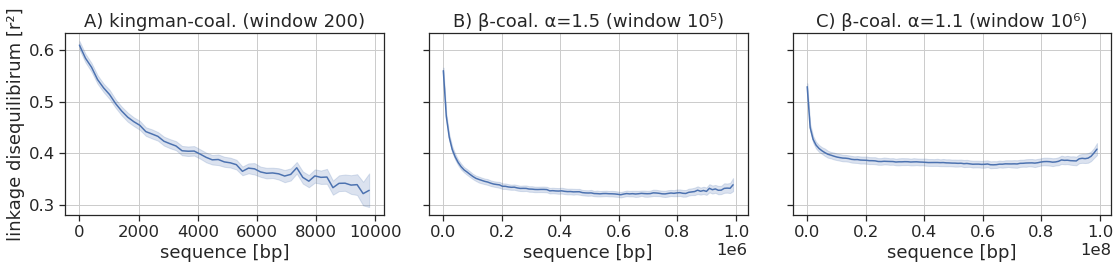

In [13]:

sns.set(font_scale=1.5)
sns.set_style("ticks")

fig, ax = plt.subplots(1, 3, figsize=(16,4), sharex=False, sharey=True)

dfs = kingman_dfs
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[0])
ax[0].set_xlabel("sequence [bp]")
ax[0].set_ylabel("linkage disequilibirum [r²]")
ax[0].set_title("A) kingman-coal. (window 200)")
ax[0].grid(True)

#dfs.to_csv("a15_r2e-8_m2e-7_w50_l1e6.csv")
dfs = beta_dfs
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[1])
ax[1].set_xlabel("sequence [bp]")
ax[1].set_ylabel("linkage disequilibirum [r²]")
ax[1].set_title("B) β-coal. α=1.5 (window 10⁵)")
ax[1].grid(True)

dfs = beta_dfs_2
sns.lineplot(data=dfs, x="position", y="distance", ax=ax[2])
ax[2].set_xlabel("sequence [bp]")
ax[2].set_ylabel("linkage disequilibirum [r²]")
ax[2].set_title("C) β-coal. α=1.1 (window 10⁶)")
ax[2].grid(True)

plt.tight_layout()

fig.savefig("../figures/figure_2", dpi=500)

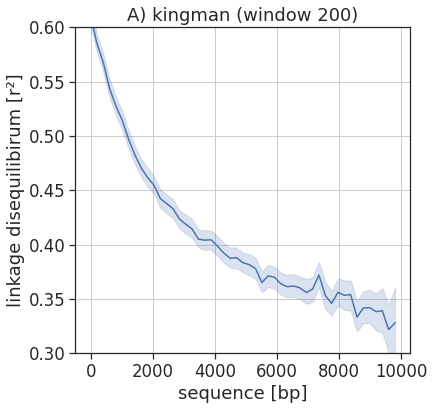

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=False, sharey=False)
dfs = kingman_dfs
sns.lineplot(data=dfs, x="position", y="distance", ax=ax)
ax.set_xlabel("sequence [bp]")
ax.set_ylabel("linkage disequilibirum [r²]")
ax.set_title("A) kingman (window 200)")
ax.grid(True)
ax.set(ylim=(0.30, 0.6))
fig.savefig("../figures/figure_2_A", dpi=500)

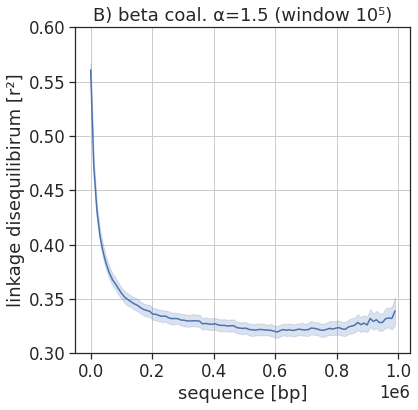

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=False, sharey=False)
dfs = beta_dfs
sns.lineplot(data=dfs, x="position", y="distance", ax=ax)
ax.set_xlabel("sequence [bp]")
ax.set_ylabel("linkage disequilibirum [r²]")
ax.set_title("B) beta coal. α=1.5 (window 10⁵)")
ax.grid(True)
ax.set(ylim=(0.30, 0.6))
fig.savefig("../figures/figure_2_B", dpi=500)

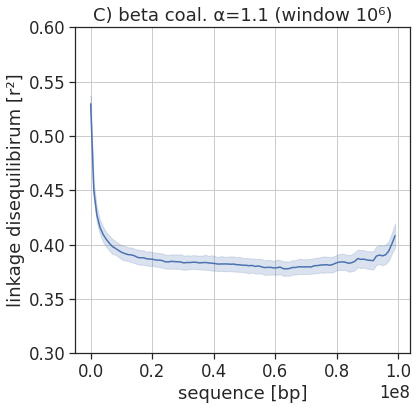

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=False, sharey=False)
dfs = beta_dfs_2
sns.lineplot(data=dfs, x="position", y="distance", ax=ax)
ax.set_xlabel("sequence [bp]")
ax.set_ylabel("linkage disequilibirum [r²]")
ax.set_title("C) beta coal. α=1.1 (window 10⁶)")
ax.set(ylim=(0.3, 0.6))
ax.grid(True)
fig.savefig("../figures/figure_2_C", dpi=500)

In [99]:
kingman_dfs.to_csv("kingman_ld.csv")
beta_dfs.to_csv("mmc_1.5_ld.csv")
beta_dfs_2.to_csv("mmc_1.1_ld.csv")